In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit
import numexpr as ne
plt.style.use('ggplot')
%matplotlib inline

In [2]:
from sklearn.metrics import zero_one_loss, accuracy_score

In [3]:
train_data = pd.read_csv("http://www.csie.ntu.edu.tw/~htlin/course/ml15fall/hw7/hw7_train.dat", header=None, delim_whitespace = True)
train_x = np.array(train_data.iloc[:,:-1])
train_y = np.array(train_data.iloc[:,-1])
test_data = pd.read_csv("http://www.csie.ntu.edu.tw/~htlin/course/ml15fall/hw7/hw7_test.dat", header=None, delim_whitespace = True)
test_x = np.array(test_data.iloc[:,:-1])
test_y = np.array(test_data.iloc[:,-1])

# CART

In [4]:
class DecesionTree():
    def __init__(self, tp = "tree", depth = 0):
        self.tp = tp
        self.value = None
        self.left = None
        self.right = None
        self.i = None
        self.theta = None
        self._gini = 1.
        self.depth = depth
        
        
    def fit(self, x, y):
        r, g = self._branch(x,y)
        if not r:
            self.value = y[0]
            self.tp = "leaf"
            return

        index_l = (g==-1)
        index_r = (g==1)
        self.left = DecesionTree(depth = self.depth+1)
        self.right = DecesionTree(depth = self.depth+1)
        self.left.fit(x[index_l], y[index_l])
        self.right.fit(x[index_r], y[index_r])
    
    def gini(self,y):
        N = float(y.shape[0])
        return 1-(((y==1).sum())**2 + ((y==-1).sum())**2)/N**2
    
    def _branch(self, x, y):
        self.i = None
        self.theta = None
        self._gini = self.gini(y)
        x_t = x.T.copy()
        x_t.sort()
        best_g = None
        find = False
        N = float(y.shape[0])
        for i in xrange(x_t.shape[0]):
            theta_vector = (x_t[i][:-1]+x_t[i][1:])/2
            for j in xrange(len(theta_vector)):
                theta = theta_vector[j]
                g = np.sign(x.T[i]-theta)
                idx_p = (g==1)
                idx_n = (g==-1)
                frac_p = idx_p.sum()/N
                frac_n = idx_n.sum()/N
                # print frac_p, frac_n
                gini_split = self.gini(y[idx_p])*frac_p + self.gini(y[idx_n])*frac_n
                if gini_split < self._gini:
                    find = True
                    self.theta = theta
                    self.i = i
                    self._gini = gini_split
                    best_g = g
        return find, best_g
    
    def predict(self, x):
        g = np.zeros(x.shape[0])
        idx = np.ones(x.shape[0], dtype=np.bool)
        self._predict(x, g, idx)
        return g
    
    def _predict(self, x, g , idx):
        if self.tp == "leaf":
            g[idx] = self.value
            return
        _g = np.sign(x.T[self.i]-self.theta)
        idx_left = (_g==-1)*idx
        idx_right = (_g==1)*idx
        self.left._predict(x, g, idx_left)
        self.right._predict(x, g, idx_right)
        return
        
    
    def __str__(self):
        to_return = ''
        if self.tp =="leaf":
            return ' {0}'.format(self.value)
        template = '''{indent}>i = {i}, theta = {theta}
{indent}|negative:{left}
{indent}|positive:{right}'''
        to_return = template.format(i = self.i, theta = self.theta, indent = '|'*self.depth, 
                               left = str(self.left), right = str(self.right))
        if self.depth > 0:
            to_return = '\n' + to_return
        return to_return

## Problem 13

In [5]:
t = DecesionTree()

In [6]:
t.fit(train_x, train_y)

In [7]:
print t

>i = 1, theta = 0.626233
|negative:
|>i = 0, theta = 0.2244395
||negative:
||>i = 1, theta = 0.11515275
|||negative: 1
|||positive: -1
||positive:
||>i = 0, theta = 0.541508
|||negative:
|||>i = 1, theta = 0.3586205
||||negative:
||||>i = 0, theta = 0.501625
|||||negative: 1
|||||positive: -1
||||positive:
||||>i = 0, theta = 0.2607515
|||||negative: 1
|||||positive: -1
|||positive:
|||>i = 1, theta = 0.285925
||||negative:
||||>i = 1, theta = 0.2660385
|||||negative: 1
|||||positive: -1
||||positive: 1
|positive:
|>i = 0, theta = 0.8781715
||negative: -1
||positive: 1


## Problem 14

In [8]:
print "E_in =", zero_one_loss(t.predict(train_x), train_y)

E_in = 0.0


## Problem 15

In [9]:
print "E_out =", zero_one_loss(t.predict(test_x), test_y)

E_out = 0.126


# Random Froest

In [10]:
from sklearn.tree import DecisionTreeClassifier

In [11]:
class RandomForest():
    def __init__(self, T = 5, max_depth = None):
        self.T = T
        self.forest = []
        self.max_depth = max_depth
    def fit(self, x, y):
        N = y.shape[0]
        for t in xrange(self.T):
            idx = np.random.randint(0,N,N)
            tree = DecisionTreeClassifier(max_depth=self.max_depth)
            tree.fit(x[idx], y[idx])
            self.forest.append(tree)
    def predict(self, x, t_num = None):
        if not t_num:
            t_num = self.T
        gs = [t.predict(x) for t in self.forest[:t_num]]
        g = np.sign(sum(gs))
        return g

## Problem 16

In [12]:
T = 30000

In [13]:
rf = RandomForest(T = T)

In [14]:
rf.fit(train_x, train_y)

In [15]:
index = np.array(xrange(T))+1

In [16]:
E_in_tree = []
g_in = []
for tree in rf.forest:
    g = tree.predict(train_x)
    g_in.append(g)
    E_in_tree.append(zero_one_loss(g, train_y))

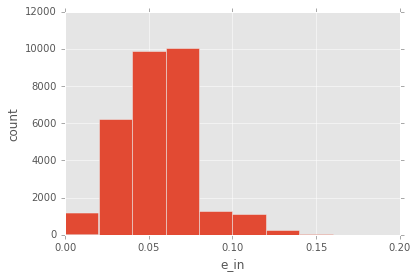

In [17]:
plt.hist(E_in_tree)
plt.xlabel("e_in")
plt.ylabel("count")
plt.savefig("p16")

In [18]:
np.average(E_in_tree)

0.052135333333333346

## Problem 17

In [19]:
G_in = np.sign(np.cumsum(g_in, axis=0))
E_in_RF = [zero_one_loss(g, train_y) for g in G_in]

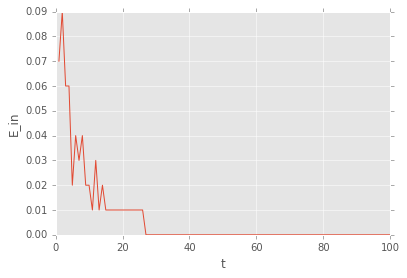

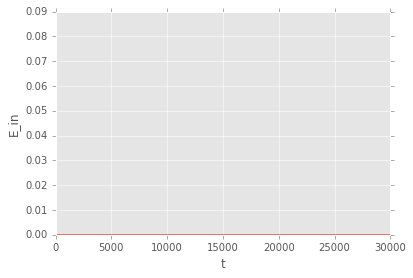

In [20]:
plt.plot(index[:100], E_in_RF[:100])
plt.xlabel("t")
plt.ylabel("E_in")
plt.savefig("p17-1")
plt.show()
plt.plot(index, E_in_RF)
plt.xlabel("t")
plt.ylabel("E_in")
plt.savefig("p17-2")
plt.show()

## Problem 18

In [21]:
E_out_tree = []
g_out = []
for tree in rf.forest:
    g = tree.predict(test_x)
    g_out.append(g)
    E_out_tree.append(zero_one_loss(g, test_y))

In [22]:
G_out = np.sign(np.cumsum(g_out, axis=0))
E_out_RF = [zero_one_loss(g, test_y) for g in G_out]

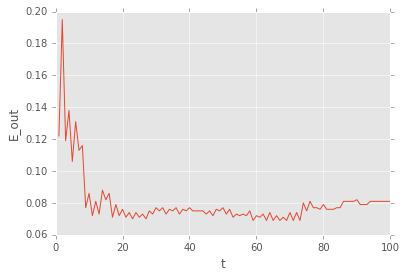

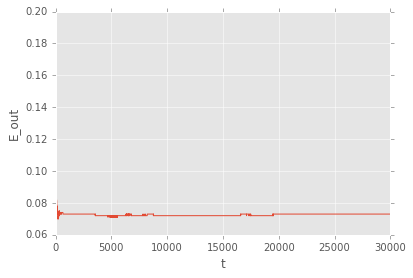

In [23]:
plt.plot(index[:100], E_out_RF[:100])
plt.xlabel("t")
plt.ylabel("E_out")
plt.savefig("p18-1")
plt.show()
plt.plot(index, E_out_RF)
plt.xlabel("t")
plt.ylabel("E_out")
plt.savefig("p18-2")
plt.show()

In [24]:
rfd = RandomForest(T = T, max_depth=1)

In [25]:
rfd.fit(train_x, train_y)

In [26]:
E_in_ds = []
g_in_ds = []
for tree in rfd.forest:
    g = tree.predict(train_x)
    g_in_ds.append(g)
    E_in_ds.append(zero_one_loss(g, train_y))

In [27]:
G_in_D = np.sign(np.cumsum(g_in_ds, axis=0))
E_in_RFD = [zero_one_loss(g, train_y) for g in G_in_D]

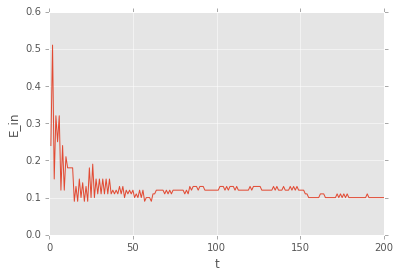

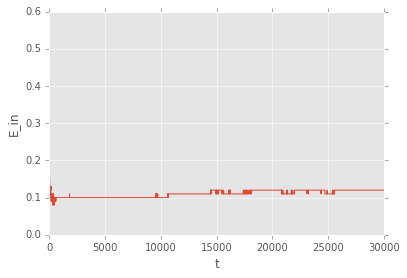

In [28]:
plt.plot(index[:200], E_in_RFD[:200])
plt.xlabel("t")
plt.ylabel("E_in")
plt.savefig("p19-1")
plt.show()
plt.plot(index, E_in_RFD)
plt.xlabel("t")
plt.ylabel("E_in")
plt.savefig("p19-2")
plt.show()

In [29]:
E_out_ds = []
g_out_ds = []
for tree in rfd.forest:
    g = tree.predict(test_x)
    g_out_ds.append(g)
    E_out_ds.append(zero_one_loss(g, test_y))

In [30]:
G_out_D = np.sign(np.cumsum(g_out_ds, axis=0))
E_out_RFD = [zero_one_loss(g, test_y) for g in G_out_D]

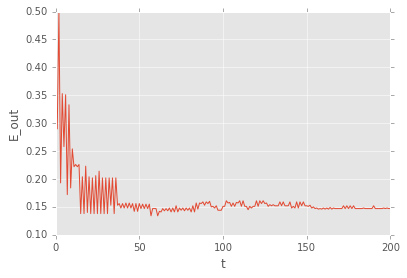

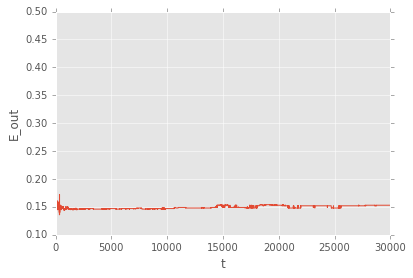

In [31]:
plt.plot(index[:200], E_out_RFD[:200])
plt.xlabel("t")
plt.ylabel("E_out")
plt.savefig("p20-1")
plt.show()
plt.plot(index, E_out_RFD)
plt.xlabel("t")
plt.ylabel("E_out")
plt.savefig("p20-2")
plt.show()